# Transformer Language Modeling

This notebook shows how to implement and train a decoder-only transformer for language modeling. It was created to deepen my own understanding of transformers, but I hope it can also be a helpful resource for others wanting to learn more about this topic.


## Getting started

If you're opening this Notebook on colab, you will need to clone the repo and change working directory. Update the `do_clone` variable below to `True` and run the cell.


In [1]:
do_clone = False

if do_clone:
    !git clone https://github.com/jbergq/transformer.git
    %cd transformer

In [2]:
%%capture
%pip install portalocker
%pip install -r requirements.txt
%pip install pyarrow
%pip install --upgrade numpy

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/jonathanb/git/transformer/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

Now, let's create a configuration class that we will use to configure the remaining code in the notebook.


In [4]:
from dataclasses import dataclass, asdict


# Base config, partly adopted from nanoGPT by Andrej Karpathy
@dataclass
class Config:
    model_name: str = "toy-model"
    val_size: int = 1000  # Size of validation set.
    max_iters: int = 600000  # Total num training iterations.
    eval_iters: int = 100  # Number of evaluation iterations.
    eval_interval: int = 1000
    effective_batch_size: int = 512
    batch_size: int = 4
    grad_accum_steps: int = 1
    lr: float = 1e-3
    warmup_iters: int = 2000
    lr_decay_iters: int = 600000  # Should be ~= max_iters per Chinchilla.
    min_lr: float = 6e-5  # Minimum lr, should be ~= lr/10 per Chinchilla.
    weight_decay: float = 0.0005
    print_example: bool = True


cfg = Config()

# Derive accumulation steps to get target effective batch size.
if cfg.effective_batch_size is not None:
    cfg.grad_accum_steps = cfg.effective_batch_size // cfg.batch_size

# Set model hparams.
if cfg.model_name == "toy-model":
    cfg.context_size = 64
    cfg.embedding_size = 128
    cfg.ff_hidden_size = 256
    cfg.head_size = None
    cfg.num_blocks = 4
    cfg.num_heads = 4
elif cfg.model_name == "gpt2-small-custom":
    cfg.context_size = 1024
    cfg.embedding_size = 768
    cfg.ff_hidden_size = 3072
    cfg.head_size = None
    cfg.num_blocks = 12
    cfg.num_heads = 12

if cfg.head_size is None:
    cfg.head_size = cfg.embedding_size // cfg.num_heads

asdict(cfg)

{'model_name': 'toy-model',
 'val_size': 1000,
 'max_iters': 600000,
 'eval_iters': 100,
 'eval_interval': 1000,
 'effective_batch_size': 512,
 'batch_size': 4,
 'grad_accum_steps': 128,
 'lr': 0.001,
 'warmup_iters': 2000,
 'lr_decay_iters': 600000,
 'min_lr': 6e-05,
 'weight_decay': 0.0005,
 'print_example': True}

## Model implementation


This section shows how to implement a transformer decoder, the version of the transformer suitable for language modeling.


### Language modeling

As the name implies, language modeling is the task of modeling natural language. Natural language is naturally represented as written text, or sequences of symbols, so the data used in this domain is therefore inherently sequential. Once trained on a large training set of text, often called _corpus_, a language model should learn to generate text that mimics the distribution of the training set. Mathematically, this means that a language model learns to model the probability distribution $p(x)$, where $x$ are varying length sequences of symbols $(s_1, ..., s_n)$.

The probability distribution $p(x)$ can be factored into a product of conditional probabilities:

\begin{align*}
p(x) = \prod_{i=1}^n p(s_i | s_1, ..., s_{i-1})
\end{align*}

Hence, if a language model can learn to model the conditional distributions on the right-hand side, $x \sim p(x)$ can be sampled by iteratively sampling $s_i$ from the language model and appending them to its input. Language models like these are called _auto-regressive_.

Thus, the task is to learn to model $p(s_i | s_1, ..., s_{n-i})$. The simplest way to translate this into a machine learning problem is to have the model predict a probability distribution over the entire vocabulary given $(s_1, ..., s_{i-1})$ as input, often called the _context_. For a training set of sequences $(x_1, ..., x_k)$, each consisting of sequences $(s_1, ..., s_n)$ of varying length $N$, we can form training pairs $(x, y)$ by extracting all sub-sequences on the form $\big((s_1, ..., s_{i-1}), s_i \big)$ for $2 \leq i \leq N$.

Let's look at an example where the sequence is a normal sentence of words:


In [5]:
import re

example_sentence = "Code morphs into wisdom, bridging gaps in understanding."

# Split into list of words and punctuation symbols.
words = re.findall(r"\w+|[^\w\s]", example_sentence)

f_str = "{: <60} {}"
print(f_str.format("Input", "Target"))
print("-" * 80)
for i in range(1, len(words)):
    print(f_str.format(" ".join(words[:i]), str(words[i])))

Input                                                        Target
--------------------------------------------------------------------------------
Code                                                         morphs
Code morphs                                                  into
Code morphs into                                             wisdom
Code morphs into wisdom                                      ,
Code morphs into wisdom ,                                    bridging
Code morphs into wisdom , bridging                           gaps
Code morphs into wisdom , bridging gaps                      in
Code morphs into wisdom , bridging gaps in                   understanding
Code morphs into wisdom , bridging gaps in understanding     .


The left column shows the input sequences $(s_1, ..., s_{i-1})$ and the right column the targets $s_i$.

For most language models though, words in the form of text is not an suitable representation since arithmetic operations cannot be applied to it. We therefore need to convert the text into a numeric format, which we look into next.


### Tokens

Converting text into a numeric representation is typically called _tokenization_, and the elements of this representation are called _tokens_. In the simplest case, a text can be tokenized by splitting it into words and special symbols, just like the example above, and forming an ordered set called a _vocabulary_. When tokenizing a text, each word or symbol is replaced by its index in the vocabulary.

Using words as tokens is a perfectly valid form of tokenization, but it has a drawback — it tends to lead to very large vocabularies (the Oxford English Dictionary contains about 170 000 words). As we will see later, the model's input and output layers scale with vocabulary size, so this tends to make its memory and compute footprint undesirably large.

The other extreme would be to use the smallest units of written text as tokens, namely characters. For example, ASCII contains just 128 unique symbols and can represent most written text. Double the number of symbols to 256 and practically all text on the internet can be represented with this small vocabulary. The problem with this approach is that it becomes much more difficult to learn what any given symbol represents. A character alone can hardly be said to represent much, so this type tokenization scheme tends to be detrimental to the model's performance.

The sweet spot in between these two is to use a scheme called _sub-word tokenization_, where words are split into parts which are tokenized. Of course, the question then becomes how to do the splitting, for which there are many approaches.

TODO what _are_ tokens? How should they be understood in other modalities?


We will be using the same tokenizer as GPT-2, which is a sub-word tokenizer based on a modified version of a technique called Byte Pair Encoding (BPE).

Let's use Hugging Face's `transformers` package to load it:


In [6]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Let's tokenize the example sentence and decode it back to text to see how the sub-word tokenizer operates.


In [7]:
# GPT-2 used a subword tokenizer, meaning that each token corresponds to part of a word
str_enc = tokenizer.encode(example_sentence)  # Tokenized string
print("Tokenized: ", str_enc)
print("Decoded: ", [tokenizer.decode([s]) for s in str_enc])

Tokenized:  [10669, 17488, 82, 656, 11501, 11, 38265, 2667, 17332, 287, 4547, 13]
Decoded:  ['Code', ' morph', 's', ' into', ' wisdom', ',', ' brid', 'ging', ' gaps', ' in', ' understanding', '.']


We see that some words have indeed been split into sub-words, but others are kept intact. Most sub-word tokenizers aim to split words into meaningful units that can be composed together. For example, we see that the word "morphs" is split into "morph" and "s". Because of that, the model only has to learn the meaning of "morph" once, instead of separately for each of its grammatical variations. Additionally, it can now learn the general rule of how adding an "s" modifies the tense of the verb.

In summary, tokenization is a crucial data preparation step for training language models. Furthermore, the transformer architecture is increasingly used for other data modalities such as vision and there is ongoing research on how to best perform tokenization for these domains. TODO finish.


### Transformer decoder

In this section, we will be implementing a decoder-only transformer, the version of the transformer suitable for language modeling. The diagram below shows its architecture.

<img src="https://github.com/jbergq/transformer/blob/main/images/transformer_decoder_preln.svg?raw=1" height=720></img>

We see that there are only a few constituent parts that make up the model architecture. These are:

- A token embedding layer
- $N$ transformer decoder blocks stacked sequentially
- A classification head

In the bottom of the image we also see the input sequence of tokens, denoted by $(s_1, s_2, s_3, ..., s_n)$. As described in the previous chapter, the transformer predicts the next token in the sequence, $s_{n+1}$, as a probability distribution over the vocabulary as a floating point vector, shown in the top of the image.

Now, you may notice that there are multiple outputted probability vectors. The reason is this: While we _could_ train the transformer to only predict $s_{n+1}$, we would not be making the most out of our training data. Each sequence $(s_1, s_2, s_3, ..., s_n, s_{n+1})$ contains $n$ perfectly valid training examples $\big((s_1), s_2\big)$, $\big((s_1, s_2), s_3\big)$, $\big((s_1, s_2, s_3), s_4\big)$ and so on. We will be training the transformer to predict all of these _in parallel_.

TODO expand on how transformers are suitable for parallelization.

<!-- Therefore, given a training example sequence ${ s_1, s_2, s_3, ..., s_t, s_{t+1} }$, we will form an input sequence ${ s_1, s_2, ..., s_t }$ and a target sequence ${ s_2, s_3, ..., s_{t+1} }$.

Here is a code example: -->

Let's break down the transformer architecture and go over each layer separately, starting with the first — token embeddings.


### Token embeddings

<img src="https://github.com/jbergq/transformer/blob/main/images/transformer_embedding.svg?raw=1"></img>

Simply put, the token embedding layer maps each token in the input sequence to learned vector representations called embeddings. Once trained, these embeddings can be thought of as representing various linguistic features of each token in the input, such as whether it is a verb or noun, singular or plural, etc. Tokens similar in meaning will likely share many such linguistic features, which means that their embeddings will be in close proximity in the embedding space. Embeddings therefore also provide a mathematical representation of the relatedness _between_ different tokens.

Let's implement a simple token embedding using PyTorch's built-in `nn.Embedding` module. It is essentially a huge lookup table, with each row being the embedding vector for the token with that row number as value. The embeddings consist of parameters that can be trained via normal backpropagation. Since there are `vocab_size` tokens and each embedding has size `embedding_dim`, the embedding table has shape `(vocab_size, embedding_dim)`.


In [8]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, tokens):
        return self.embedding(tokens)

So is that it? Not quite. While we could train our transformer with only token embeddings, the transformer architecture itself has no notion of the _positions_ of tokens in the sequence. In natural language, the order of words can completely change the meaning of a sentence, so it is important for our embeddings to reflect this information as well. A conventional way to address this for transformers is to create another embedding that is simply added onto the token embeddings to inject information about its position, called a _positional encoding_. Let's see how it can be implemented.

#### Positional encoding

For a sequence length of $N$, we want to generate $N$ vectors that can uniquely represent each position in the sequence. We also want TODO.

TODO desirable properties etc


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, context_size, embedding_size, n=10000):
        super().__init__()

        i = torch.arange(embedding_size // 2)
        k = torch.arange(context_size).unsqueeze(dim=1)

        pos_embeddings = torch.zeros(context_size, embedding_size, requires_grad=False)
        pos_embeddings[:, 0::2] = torch.sin(k / (n ** (2 * i / embedding_size)))
        pos_embeddings[:, 1::2] = torch.cos(k / (n ** (2 * i / embedding_size)))

        self.register_buffer("pos_embeddings", pos_embeddings)

    def forward(self, x):
        return self.pos_embeddings[: x.shape[1], :]

Let's create a single layer called a `TransformerEmbedding` that combines both of these embeddings.


In [10]:
class TransformerEmbedding(nn.Module):
    def __init__(self, hidden_size, vocab_size, context_size) -> None:
        super().__init__()

        self.token_embedding = TokenEmbedding(vocab_size, hidden_size)
        self.pos_embedding = PositionalEncoding(context_size, hidden_size)

    def forward(self, x):
        return self.token_embedding(x) + self.pos_embedding(x)

### Transformer blocks

Next, we take a look at the decoder transformer block.

<img src="https://github.com/jbergq/transformer/blob/main/images/transformer_block.svg?raw=1"></img>

Transformers, like many other neural networks, are made by stacking multiple computational blocks in a sequence. For decoder-type transformers, the blocks contain two main components:

- A masked multi-head attention layer, applied across the whole sequence.
- A feedforward block, applied to each token separately.

By alternating between *inter-token communication* and *per-token processing*, transformers are able to produce sophisticated representations of language. Note that other than the attention layer, all layers in a transformer are applied to each token separately. It is only through attention that token-to-token interaction is considered.

*Decoder* transformer blocks have a single property that defines them: they use _masked_ attention. This means that any given token only attends to the tokens that come before it, making the attention _causal_. More on this later.


#### Attention mechanism

Attention is arguably the most characteristic and important feature of transformers as it allows them to learn the contextual relationships *between* tokens. When attention is applied between tokens of the same sequence, it is called *self-attention*. For decoder transformers, this is the only form of attention used.

There are multiple ways of implementing attention in neural networks, but the type commonly used in transformers is called _scaled dot product attention_. We will see how it works below.

#### Summarizing the context

First, let's look at a simplified example to build up intuition for why the full implementation takes the form it does. Recall that the transformer's objective is to predict the next token given the input sequence:

\begin{align*}
p(s_{n+1} | s_{1}, ..., s_n)
\end{align*}

To do this, the transformer needs a way to encode information about the input sequence $(s_{1}, ..., s_{n})$, called the _context_.

<!--
Note: Masked (causal) attention makes training and inference more efficient since you can train on all sub-examples in parallel and reuse embeddings during inference.
You *could* have classification head only predict the next token given the context and not use masking. Would anything be gained from this?
-->

One way to summarize the context would be to simply take the mean of the token embeddings $e_1, e_2, ..., e_{i}$ and use the resulting vector to predict $p(s_{i+1} | s_{1}, ..., s_i)$.

Remember that our transformer will predict the next token for *each* position $i$ in the input sequence, so we form one average per position $i$ on the form:

\begin{align}
\bar{e}_i = \frac{1}{i} \sum_j^i e_j
\end{align}

<!-- TODO illustrative figure -->

However, there are two problems with this approach:

1. All elements of the sum are given the same "weight" $\frac{1}{i}$ and therefore contribute equally to the result. In reality, some words may actually be more important than others for doing the prediction.
2. The result is the same regardless of the order of $e_j$. This is problematic since meaning in language is highly dependent on the order of words.

We will see that scaled dot product attention combined with the positional encodings explained earlier addresses both of these concerns.

<!-- Point 3. means that we have to consider

Why not have the model learn to *predict* the weights $w_j$?

The way this is done in scaled dot product attention is as follows: -->

#### Scaled dot product attention

To improve upon the earlier example and better encode the context, we would like to have a way of computing the weighted sum

\begin{align*}
\bar{e}_i = \sum_j^i w_{ij} e_j
\end{align*}

with the weights $w_{ij}$ reflecting the "importance" of token $j$ for token $i$. Better yet, we would like the weights to also take the position $j$ in relation to the position $i$ into consideration.

<!-- 
But what is even the importance of an embedding? Well, it likely depends on a variety of factors. Let's see if we can think of a few:

1. The semantic meaning of the token. For example, TODO.
2. The position of the token in the sentence. For example, the last word with position $t$ will likely be useful when predicting
3. The position of the token in relation to other tokens and their positions. For example, TODO. -->

To achieve this, we will design a mechanism for the model to learn to *predict* the weights $w_{ij}$. We will call $w_{ij}$ the *attention* or *attention score* between token $i$ and token $j$.

The idea is as follows: For *each* token, we predict two embeddings, $q$ and $k$, called its $query$ and $key$. The weight $w_{ij}$ will then be formed by taking the dot product between the query of token $i$ and the key of token $j$:

\begin{align*}
w_{ij} = q_i \cdot k_j
\end{align*}

Intuitively, queries can be thought of as representing what the token at position $i$ being summarized is "looking for", and the key represents what other tokens "provide".

To predict $q$ and $k$, we introduce two simple linear mappings (weight matrices), $W_Q$ and $W_K$, which map each embedding $e_i$ to its key and query embeddings $q_i$ and $k_i$.

\begin{align*}
q_i = W_Q e_i \quad k_i = W_K e_i
\end{align*}

Now, recall that at least in the initial decoder block, each embedding $e_i$ consists of two terms, namely the token embedding and positional encoding:

\begin{align*}
e_i = t_i + p_i
\end{align*}

Substituting all of this in equation TODO above yields

\begin{align*}
w_{ij} &= q_i \cdot k_j = W_Q e_i \cdot W_K e_j = e_i^\intercal W_Q^\intercal W_K e_j = (t_i + p_j)^\intercal W_Q^\intercal W_K (t_j + p_j) \\
&= \underbrace{ t_i^\intercal W_Q^\intercal W_K t_j}_\text{token i to token j} + \underbrace{ t_i^\intercal W_Q^\intercal W_K p_j}_\text{token i to position j} + \underbrace{ p_i^\intercal W_Q^\intercal W_K t_j }_\text{position i to token j} + \underbrace{ t_i^\intercal W_Q^\intercal W_K t_j }_\text{position i to position j}
\end{align*}

Hence, the weights $w_{ij}$ will take into account both the relative semantic meaning and the relative positions between token pairs. The weight matrices $W_Q$ and $W_K$ are simply trained through normal gradient descent.

Now, there are a few missing pieces before we have arrived at the full scaled dot product attention implementation. First, our notation becomes more concise if we swap to matrices instead. The weighted sum in equation TODO can be rewritten as the following matrix equation:

\begin{align*}
\bar{E} = W E = Q K^\intercal E
\end{align*}

with $W$ containing the weights $w_{ij}$ and $E, Q, K$ containing the embeddings $e_i$, queries $q_i$ and keys $k_i$ as columns.

Further, the weights $w_{ij}$ are currently unbounded. To keep the interpretation as a weighted sum, we normalize them to sum to 1 by taking the softmax along each row.

\begin{align*}
\bar{E} = softmax(Q K^\intercal) E
\end{align*}

In practice, it has been found that the raw dot products $Q K^\intercal$ can be spiky early in training, resulting in a non-uniform softmax distribution. This amounts to the model randomly starting out with strong attention towards particular tokens, taking time to unlearn and thus slowing down the training. This can be avoided by normalizing $Q K^\intercal$ by its standard deviation, which can be worked out to be $\sqrt{d_k}$, where $d_k$ is the embedding size.

\begin{align*}
\bar{E} = softmax(\frac{Q K^\intercal}{\sqrt{d_k}} ) E
\end{align*}

Finally, we have one missing piece: Instead of summing over the embeddings $e_i$ as in equation TODO, we introduce a third linear mapping $W_V$ to map them to embeddings $v_i$ called *values*. This is done for multiple reasons, among others:
1. It allows the triplets $q_i, k_i, v_i$ to have a different embedding size compared to $e_i$
2. Since $W_V$ now maps $e_i$ to $v_i$, it can learn to focus on particular semantic concepts to pass on through the sum TODO for summarizing the context.
3. As we will see in a second, we will use *multiple* scaled dot product attention layers *in parallel*, each being a so-called *head*. Each head will have its own matrix triplets $W_Q, W_K, W_V$ and can therefore specialize on particular semantic concepts.    

Replacing $E$ with $V = W_V E$ in the equation TODO gives us the final equation for the scaled dot product attention, as first presented in the original paper:

\begin{align*}
Attention(Q, K, V) = softmax(\frac{Q K^\intercal}{\sqrt{d_k}} ) V
\end{align*}

TODO Lookahead masking

All right, now let's see how we can implement this in code. We create a new module called `ScaledDotProductAttention` which will perform the operations in equation TODO with queries, keys and values as input.

In [11]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        batch_size, head, seq_length, head_size = k.shape

        # Get attention scores through scaled dot product between queries and keys.
        score = (q @ k.transpose(2, 3)) / math.sqrt(head_size)

        # Prevent tokens attending to future tokens (decoder feature). Mask-fill these
        # attention scores such that they are zeroed in softmax.
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        # Softmax attention scores to make them sum to 1.
        score = self.softmax(score)

        return score @ v

Next, we will create another module called  `MultiHeadAttention`. All it does is simply to take the embeddings $e_i$ as input, compute the queries, keys and values *for each head* in parallel, perform the attention operation and pass the concatenated result through a linear layer to project it back down to the original embedding dimension.

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_size, head_size, num_heads=8):
        super().__init__()

        self.head_size = head_size
        self.num_heads = num_heads

        self.attention = ScaledDotProductAttention()

        self.lin_q = nn.Linear(embedding_size, head_size * num_heads)
        self.lin_k = nn.Linear(embedding_size, head_size * num_heads)
        self.lin_v = nn.Linear(embedding_size, head_size * num_heads)

        self.lin_concat = nn.Linear(head_size * num_heads, embedding_size)

    def forward(self, x, mask=None):
        # Get keys, queries and values for each head and token.
        q, k, v = self.lin_q(x), self.lin_k(x), self.lin_v(x)
        q, k, v = self.split(q), self.split(k), self.split(v)

        # Get attention-weighted token values for each head.
        out = self.attention(q, k, v, mask)

        # Concatenate head values and process for each token separately.
        out = self.concat(out)
        out = self.lin_concat(out)

        return out

    def split(self, x):
        batch_size, seq_len, hidden_size = x.shape

        return x.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1, 2)

    def concat(self, x):
        batch_size, num_heads, seq_len, head_size = x.shape
        hidden_size = head_size * num_heads

        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, hidden_size)

That's it! We have implemented masked multi-head attention, the first out of two main componenters in the transformer block. Next, let's take a look at the second, the feedforward block.

#### Feedforward block

We have now seen how the attention layer provides a mechanism for summarizing the input context by taking relationships between tokens into account. However, it does not inherently alter the representation of the input, so we also need a way to *process* the result. Typically, a simple feedforward block is used for this. It simply consists of two linear layers with non-linear activation functions, one for mapping the input into a higher-dimensional space and another for "projecting" it down to the original space again.

We create a module called `FeedForward` for this:

In [13]:
class FeedForward(nn.Module):
    def __init__(self, in_size, hidden_size, dropout_prob=0.1):
        super().__init__()

        self.lin1 = nn.Linear(in_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.lin2 = nn.Linear(hidden_size, in_size)

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return x

Finally, let's create the `DecoderBlock` and put it all together. 

In [14]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        hidden_size,
        ff_hidden_size,
        head_size,
        num_heads,
        dropout_prob=0.1,
        layer_norm_eps=1e-5,
    ):
        super().__init__()

        self.norm1 = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.attention1 = MultiHeadAttention(hidden_size, head_size, num_heads)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.norm2 = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.ff_block = FeedForward(hidden_size, ff_hidden_size, dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, lookahead_mask=None):
        # Pre-LN norm.
        x_n = self.norm1(x)

        # Inter-token communication via attention.
        x_a = self.attention1(x_n, mask=lookahead_mask)

        # Skip and dropout.
        x = self.dropout1(x + x_a)

        # Pre-LN norm.
        x = self.norm2(x)

        # Per-token processing via feedforward block.
        x_f = self.ff_block(x)

        # Skip and dropout.
        x = self.dropout2(x + x_f)

        return x

### Classification head

The final layer to implement is the classification head. This simply takes the embeddings outputted by the final `DecoderBlock` and predicts the next token for each position in the input. Remember that each token prediction is made by forming a probability distribution over the vocabulary. We simply predict the logits with a linear layer that will go into a softmax outside of the model for the probabilities.

Here it is:

In [15]:
class Classifier(nn.Module):
    def __init__(self, hidden_size, vocab_size) -> None:
        super().__init__()

        self.ln_final = nn.LayerNorm(hidden_size)
        self.lin_final = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # Final pre-LN norm.
        x = self.ln_final(x)

        # Predict logits across vocabulary.
        x = self.lin_final(x)

        return x

### Building the transformer

Finally, we have all the components necessary for building our transformer decoder.

In [16]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        context_size,
        embedding_size,
        ff_hidden_size,
        head_size,
        num_blocks=5,
        num_heads=8,
    ):
        super().__init__()
        self.register_buffer("tri", torch.tril(torch.ones(context_size, context_size)))

        self.embedding = TransformerEmbedding(embedding_size, vocab_size, context_size)

        self.decoder = []
        for _ in range(num_blocks):
            self.decoder.append(DecoderBlock(embedding_size, ff_hidden_size, head_size, num_heads))
        self.decoder = nn.ModuleList(self.decoder)

        self.classifier = Classifier(embedding_size, vocab_size)

    def create_lookahead_mask(self, tgt_seq_len):
        return self.tri[:tgt_seq_len, :tgt_seq_len].unsqueeze(0)

    def forward(self, x):
        # Create decoder lookahead mask according to sequence length.
        lookahead_mask = self.create_lookahead_mask(x.shape[1])

        # Embed tokens.
        x = self.embedding(x)

        # Process using decoder blocks.
        for block in self.decoder:
            x = block(x, lookahead_mask)

        # Predict next tokens.
        out = self.classifier(x)

        return out

### Dataset

We will now set up the training and validation datasets. We will use Hugging Face's `datasets` package to prepare and load the WebText dataset.


In [17]:
from datasets import load_dataset

# Load WebText dataset in streaming mode. No need to download!
dataset = load_dataset("openwebtext", streaming=True)["train"]
shuffled_dataset = dataset.shuffle(seed=42, buffer_size=10000)

# Split dataset.
train_set = shuffled_dataset.skip(cfg.val_size)
val_set = shuffled_dataset.take(cfg.val_size)

Below we define a function called `tokenize` for turning text documents from the dataset into the example input and output sequences for training the model. We will be training a language model which simply predicts the next token in a sequence given the tokens so far as input. Therefore, input sequences will just be the target sequences shifted by one index to the left.


In [18]:
from functools import partial


def tokenize(example):
    outputs = tokenizer(
        example["text"],
        truncation=True,  # Truncate returned token sequences to max_length.
        max_length=cfg.context_size + 1,  # Max length of returned token sequences.
        return_overflowing_tokens=True,  # Tokenize whole input and split into chunks.
        return_length=True,  # Return lengths of chunks.
    )

    # Create examples.
    inp_batch = []
    tgt_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == cfg.context_size + 1:  # Only include full length sequences.
            inp_batch.append(input_ids[:-1])
            tgt_batch.append(input_ids[1:])  # Note: input shifted by one.

    return {"input": inp_batch, "target": tgt_batch}


# Tokenize train and val sets.
train_tokenized = train_set.map(
    partial(tokenize),
    batched=True,
    remove_columns=train_set.column_names,
)
val_tokenized = val_set.map(
    partial(tokenize),
    batched=True,
    remove_columns=val_set.column_names,
)

We will use an "infinite training loop" to train the transformer language model, where we continue to sample random batches until we reach convergence or the maximum number of batches configured.

Let's create a dataset wrapper that will allow us to continue sampling the dataset endlessly.


In [19]:
from typing import Iterator

from torch.utils.data import IterableDataset


class InfiniteIterableDataset(IterableDataset):
    def __init__(self, hf_dataset, shuffle=False):
        self.hf_dataset = hf_dataset

    def __iter__(self) -> Iterator:
        while True:
            for item in self.hf_dataset:
                yield item

Finally, we create data loaders to sample batches from the datasets.


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    InfiniteIterableDataset(train_tokenized),
    batch_size=cfg.batch_size,
    collate_fn=lambda samples: {
        "input": torch.tensor([sample["input"] for sample in samples]),
        "target": torch.tensor([sample["target"] for sample in samples]),
    },
)
val_loader = DataLoader(
    InfiniteIterableDataset(val_tokenized),
    batch_size=cfg.batch_size,
    collate_fn=lambda samples: {
        "input": torch.tensor([sample["input"] for sample in samples]),
        "target": torch.tensor([sample["target"] for sample in samples]),
    },
)

train_iter = iter(train_loader)
val_iter = iter(train_iter)

Load a train batch and a validation batch to make sure everything works.


In [21]:
batch_train = next(train_iter)

print("Input sequence: ", batch_train["input"][0][:10])
print("Target sequence: ", batch_train["target"][0][:10])

Input sequence:  tensor([47976, 33265,    11,  5267,    13,   362,   357,    34,  4535,     8])
Target sequence:  tensor([33265,    11,  5267,    13,   362,   357,    34,  4535,     8,  6185])


In [22]:
batch_val = next(val_iter)

print("Input sequence: ", batch_val["input"][0][:10])
print("Target sequence: ", batch_val["target"][0][:10])

Input sequence:  tensor([12256, 35359, 23983,   968, 23222, 13072,  4482,   198,   198,   464])
Target sequence:  tensor([35359, 23983,   968, 23222, 13072,  4482,   198,   198,   464,  1380])


Great, it seems to work! Notice how the target sequences are just input sequences shifted one step to the left.

## Training

At last, we are ready to setup the training loop.

### Learning rate scheduling

TODO describe lr schedule and Chinchilla details


In [26]:
# Learning rate decay scheduler inspired by nanoGPT repo by Andrej Karpathy.
def get_lr(iter, warmup_iters, base_lr, min_lr, lr_decay_iters):
    # 1) linear warmup for warmup_iters steps
    if iter < warmup_iters:
        return base_lr * iter / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if iter > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (iter - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (base_lr - min_lr)

Text(0, 0.5, 'lr')

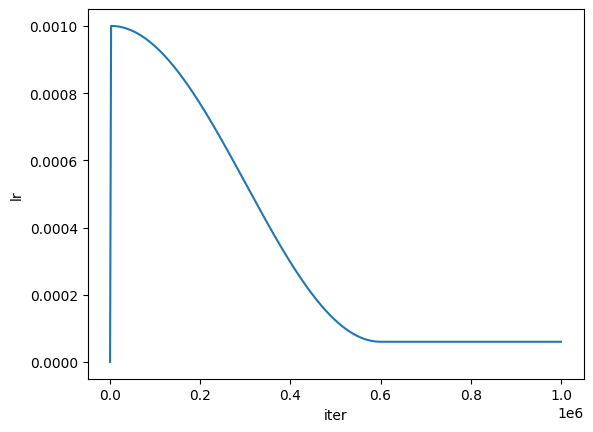

In [27]:
import matplotlib.pyplot as plt

lrs = [
    get_lr(
        iter,
        warmup_iters=cfg.warmup_iters,
        base_lr=cfg.lr,
        min_lr=cfg.min_lr,
        lr_decay_iters=cfg.lr_decay_iters,
    )
    for iter in range(0, 1_000_000, 1)
]
plt.plot(lrs)
plt.xlabel("iter")
plt.ylabel("lr")

### Expected loss

TODO scaling laws? Train ~= val loss?


In [31]:
model = TransformerDecoder(
    vocab_size=tokenizer.vocab_size,
    context_size=cfg.context_size,
    embedding_size=cfg.embedding_size,
    ff_hidden_size=cfg.ff_hidden_size,
    head_size=cfg.head_size,
    num_blocks=cfg.num_blocks,
    num_heads=cfg.num_heads,
)
model = model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, eps=5e-9)
criterion = nn.CrossEntropyLoss(ignore_index=1)

To get an estimate for what loss values are reasonable to reach, let's load the original GPT-2 using HuggingFace and evaluate it with a few samples.


In [ ]:
# Loss estimation function inspired by nanoGPT repo by Andrej Karpathy.
@torch.no_grad()
def estimate_loss(model, criterion, train_iter, val_iter, num_iters):
    iterators = {"train": train_iter, "val": val_iter}
    loss_dict = {}
    model.eval()
    for split, iterator in iterators.items():
        losses = torch.zeros(num_iters)
        for k in range(num_iters):
            batch = next(iterator)
            inp, tgt = batch["input"].to(device), batch["target"].to(device)

            out = model(inp)

            out_reshape = out.contiguous().view(-1, out.shape[-1])  # (B * T, vocab_size)
            tgt_reshape = tgt.contiguous().view(-1)  # (B * T, 1)

            loss = criterion(out_reshape, tgt_reshape)
            losses[k] = loss.item()
        loss_dict[split] = losses.mean()
    model.train()

    return loss_dict

In [32]:
from transformers import AutoModelWithLMHead, AutoConfig


class GPT2Wrapped(nn.Module):
    def __init__(self, pretrained=False) -> None:
        super().__init__()
        if pretrained:
            self.model = AutoModelWithLMHead.from_pretrained("gpt2")
        else:
            config = AutoConfig.from_pretrained("gpt2")
            self.model = AutoModelWithLMHead.from_config(config)

        self.context_size = self.model.config.n_ctx

    def forward(self, x):
        return self.model(x).logits


gpt2 = GPT2Wrapped(pretrained=True)

losses = estimate_loss(gpt2, criterion, train_iter, val_iter, 100)
losses

/home/jonathanb/git/transformer/venv/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


{'train': tensor(3.5675), 'val': tensor(3.5477)}

We see that the pre-trained GPT-2 reaches train and validation losses of about 3.5. Let's see how close we get!


### Training loop

In [33]:
from utils import train_start_print, evaluation_print, iter_print


@torch.no_grad()
def generate(model, inp_seq, context_size, max_output_len=100):
    seq = inp_seq

    for _ in range(max_output_len):
        out = model(seq[..., -context_size:])  # Truncate input sequence to max length.
        probs = F.softmax(out[:, -1, :], dim=1)
        next_tokens = torch.multinomial(probs, num_samples=1)

        # Append the next tokens to the generated sequences.
        seq = torch.cat((seq, next_tokens), dim=-1)

    return seq


fixed_inp = torch.tensor(tokenizer.encode("The"), dtype=torch.long, device=device).unsqueeze(0)

if cfg.print_example:
    batch = next(iter(train_loader))
    out = generate(model, fixed_inp, cfg.context_size)

    print("Example sequence: ", tokenizer.decode(batch["target"][0].numpy())[:200])
    print("Model output: ", tokenizer.decode(out[0].detach().cpu().numpy())[:200])

# Reinitialize data iterators.
train_iter = iter(train_loader)
val_iter = iter(train_iter)

iter_num = 0
best_val_loss = float("inf")

# Start training.
train_start_print(model)


while True:
    # Get learning rate according to schedule.
    lr = get_lr(
        iter_num,
        warmup_iters=cfg.warmup_iters,
        base_lr=cfg.lr,
        min_lr=cfg.min_lr,
        lr_decay_iters=cfg.lr_decay_iters,
    )

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # Train model on one batch.
    batch = next(train_iter)
    inp, tgt = batch["input"].to(device), batch["target"].to(device)

    out = model(inp)

    out_reshape = out.contiguous().view(-1, out.shape[-1])  # (B * T, vocab_size)
    tgt_reshape = tgt.contiguous().view(-1)  # (B * T, 1)

    train_loss = criterion(out_reshape, tgt_reshape)
    train_loss.backward()

    # Accumulate gradients for N steps and update weights.
    if (iter_num + 1) % cfg.grad_accum_steps == 0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    if iter_num > 0 and iter_num % cfg.eval_interval == 0:
        losses = estimate_loss(model, criterion, train_iter, val_iter, cfg.eval_iters)
        evaluation_print(losses)

        # Generate sample and print.
        out = generate(model, fixed_inp, cfg.context_size)
        print("Model output: ", tokenizer.decode(out[0].detach().cpu().numpy())[:200])

        # Save model checkpoint if new best validation loss.
        if losses["val"] < best_val_loss:
            torch.save(
                {
                    "iter": iter_num,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                "best.pth",
            )

    iter_print(iter_num, train_loss)
    iter_num += 1

Example sequence:  pei, Nov. 2 (CNA) Bitcoin is illegal in Taiwan, said Financial Supervisory Commission (FSC) Chairman Tseng Ming-chung (曾銘宗) on Monday after kidnappers in Taiwan tried to collect a ransom through the v
Model output:  The Koen AVGVolume alum Adams Debor MUS crochet Knifecould Graph SPR unconstitutional Haas Pixar frameworkspat drum ICE Las mysterious Apocalypse Influence 58 riperofp didnt broadcaster domest Shareel

Starting training!
Num model params: 13.446M

---------------------------------------------
Iter       Train     
---------------------------------------------
0          11.027    
50         11.01     
100        10.972    
150        10.98     
200        10.981    
250        11.018    
300        10.873    
350        10.938    
400        10.907    
450        10.933    
---------------------------------------------
Iter       Train     
---------------------------------------------
500        10.904    
550        10.783    
600        10.779    
650